# Prompt engineering

In [1]:
import google.generativeai as genai

api_key = 'your-api-key' # replace it with your own API key at https://ai.google.dev/
genai.configure(api_key=api_key)

# Set up the model
generation_config = {
  "temperature": 0.1,
  "top_p": 1,
  "top_k": 1,
  "max_output_tokens": 2048,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

model = genai.GenerativeModel(model_name="gemini-pro",
                              generation_config=generation_config,
                              safety_settings=safety_settings)



In [2]:
def get_response(heading, paragraph):

    prompt_parts = [
      '''
      **Prompt:**

      Given a chemical reaction title and a paragraph describing the reaction procedure, extract and organize the following information:
      * Reactants, Solvents, and Catalysts: List all the reactants, solvents, and catalysts involved in the reaction, using their **standardized chemical names**. Assign an unique code (e.g., A, B, C, etc.) to each compound for easy reference in the next step.
      * Reaction Steps: Simplify each step of the reaction procedure into a single string, using only the chemical names of the reactants and products.
      * Known Product: Indicate the standardized name of the products with the known chemical name.
      * Is there a clear molecule product?: Indicate whether the final product formed after the experiment is a single, well-defined molecule.
      
      **Additional Notes:**

      * Make sure all the extracted molecules are used in the reaction steps and included in the reaction strings as code (only code and mixture are allowed in the reactions strings).
      * Keep the reaction strings as simple as possible, only listing the chemical codes without any descriptors.
      * If the reaction product is \"reaction mixture, organic phase, etc.\", write \"mixture\" in the product cell. If the mixture is used in the next step, put mixture in the reactant cell. Make sure all the reactant and product cells are filled.
      * If there are multiple steps in the reaction procedure, number each step sequentially (e.g., Step 1, Step 2, etc.).
      * Be aware that all reactions should follow the law of conservation of mass.
      * The product at the last step should be consistent with the final product and not in the list of reactants.
      * Please double check if all the extracted molecules are extracted with standardized name and presence in the reaction string.
      
      **Output Format:**

      Please provide the reaction steps in a JSON format, as follows:
      ```
      {
      "Reactants, Solvents, and Catalysts":
       {
       "[Code]": "[standerdized molecule name without including any additional information such as "saturated", "concentrated, "solid" or label]"
        }
      "Products": 
      {
      "[Code]": "[standerdized molecule name without including any additional information such as "saturated", "concentrated, "solid" or label]"
      },
      "Reaction steps":
       {
       "Step X: (Action ,Temperature, and Reaction Time)": "[Reactants]+[Reactants]->[Products]"
        },
      "Is there a clear molecule product?": "[True/False]"
      }
      
      **Example:**
    
      **Heading:** %s

      **Paragraph:** %s
      ''' % (heading, paragraph)
    ]

    response = model.generate_content(prompt_parts)
    
    try:
        converted_response = eval(response.text.replace('\n', '').replace('python', '')[3:-3])
        return converted_response
    except:
        print ('failed to convert')
        return response.text

# Get response and make reaction strings

In [3]:
import xml.etree.ElementTree as ET
import os

#Calculate paragraph number in grants
grant_path = 'grants'
grant_list = os.listdir(grant_path)

 # Specify the path of XML file
sum_grant = 0
for year in grant_list:
    temp_path = grant_path + '/' + year
    grant_xml = os.listdir(temp_path)
    for xml in grant_xml:
        print (temp_path, xml)
        break
    break

grants/2013 I20130430.xml


In [4]:
def extract_headings_paragraphs(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Define the namespace used in the XML
    namespaces = {'dl': 'http://bitbucket.org/dan2097'}

    # List to hold extracted data
    extracted_data = []
    all_sources = root.findall('.//dl:source', namespaces)
    all_smiles = root.findall('.//dl:reactionSmiles', namespaces)
    # Iterate through each 'source' element in the XML
    for source, smiles in zip(all_sources, all_smiles):
        # Find the heading and paragraph text within each 'source' element
        documentId = source.find('dl:documentId', namespaces)
        heading = source.find('dl:headingText', namespaces)
        paragraph = source.find('dl:paragraphText', namespaces)

        # Get the text content, if the element exists
        documentId_text = documentId.text if documentId is not None else None
        heading_text = heading.text.split('=')[-1] if heading is not None else None
        paragraph_text = paragraph.text if paragraph is not None else None
        smiles_text = smiles.text.split(' ')[0] if smiles is not None else None
        
        # Add the extracted information to the list
        extracted_data.append({
            'documentId': documentId_text,
            'heading': heading_text, 
            'paragraph': paragraph_text, 
            'smiles': smiles_text}
        )

    return extracted_data

# Path to your XML file
file_path = temp_path + '/' + xml  # Replace with your file path
print (file_path)
# Extract the data
extracted_data = extract_headings_paragraphs(file_path)
print (len(extracted_data))

grants/2013/I20130430.xml
2436


In [5]:
i = 0
data = extracted_data[i]
data

{'documentId': 'USRE044186E1',
 'heading': None,
 'paragraph': 'L-pyroglutamic acid ethyl ester (200 g, 1.27 mol) was dissolved in 1.2 liters of methylene chloride and treated sequentially with di-tert-butyldicarbonate (297 g, 1.36 mol) and a catalytic DMAP (1.55 g, 0.013 mol) at ambient temperature. After 6 h, the mixture was quenched with saturated brine and the organic phase was dried (Na2SO4) and filtered through a short silica gel column to give 323 g (100%) of N-Boc- L-pyroglutamic acid ethyl ester. N-Boc-L-pyroglutamic acid ethyl ester (160 g, 0.62 mol) was dissolved in 1 liter of toluene, cooled to −78° C. and treated with lithium triethylborohydride (666 mL of a 1.0 M soln in THF) and added dropwise over 90 minutes. After 3 h, 2,6-lutidine (423 mL, 3.73 mol) was added dropwise followed by DMAP (0.2 g, 0.0016 mol). To this mixture was added TFAA (157 g, 0.74 mol) and the reaction was allowed to come to ambient temperature over 2 h. The mixture was diluted with EtOAc and water a

In [6]:
response = get_response(data['heading'], data['paragraph'])
response

{'Reactants, Solvents, and Catalysts': {'A': 'L-pyroglutamic acid ethyl ester',
  'B': 'methylene chloride',
  'C': 'di-tert-butyldicarbonate',
  'D': 'DMAP',
  'E': 'saturated brine',
  'F': 'Na2SO4',
  'G': 'silica gel',
  'H': 'toluene',
  'I': 'lithium triethylborohydride',
  'J': 'THF',
  'K': '2,6-lutidine',
  'L': 'TFAA',
  'M': 'EtOAc',
  'N': 'water',
  'O': '3 N HCl',
  'P': 'aqueous bicarbonate'},
 'Products': {'Q': 'N-Boc- L-pyroglutamic acid ethyl ester',
  'R': '4,5-dehydroproline ethyl ester'},
 'Reaction steps': {'Step 1: (Dissolve, Ambient temperature)': 'A+B->mixture',
  'Step 2: (Treat, Ambient temperature, 6 h)': 'mixture+C+D->Q',
  'Step 3: (Quench, Ambient temperature)': 'Q+E->mixture',
  'Step 4: (Dry, Ambient temperature)': 'mixture+F->Q',
  'Step 5: (Filter, Ambient temperature)': 'Q+G->Q',
  'Step 6: (Dissolve, -78° C)': 'Q+H->mixture',
  'Step 7: (Treat, -78° C, 90 min)': 'mixture+I->mixture',
  'Step 8: (Wait, -78° C, 3 h)': 'mixture->mixture',
  'Step 9: (T

In [18]:
import requests


def fix_name(compound_name):
    solution_descriptors = ['saturated', 'aqueous', 'concentrated', 'solid', 'solution']
    compound_name = ' '.join([n for n in compound_name.split(' ') if n[-1] != ')'])
    compound_name = ' '.join([n for n in compound_name.split(' ') if n.lower() not in solution_descriptors and len(n) > 1])
    if '- ' in compound_name:
        compound_name = compound_name.replace('- ', '-')
    if '  ' in compound_name:
        compound_name = compound_name.replace('  ', ' ')
    return compound_name
        
def get_smiles(compound_name):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{compound_name}/property/IsomericSMILES/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        smiles = data['PropertyTable']['Properties'][0]['IsomericSMILES']
        return smiles
    else:
        return "Error: Unable to fetch data"

def get_smiles_dict(response):
    smiles_dict = {}
    problem_chemicals = []
    for code, compound_name in response['Reactants, Solvents, and Catalysts'].items():
        compound_name = fix_name(compound_name)
        smiles = get_smiles(compound_name)
        if smiles == "Error: Unable to fetch data":
            problem_chemicals.append(compound_name)
            smiles_dict[code] = '[%s (NoSmi)]' % compound_name
        else:
            smiles_dict[code] = smiles

    for code, compound_name in response['Products'].items():
        compound_name = fix_name(compound_name)
        smiles = get_smiles(compound_name)
        if smiles == "Error: Unable to fetch data":
            problem_chemicals.append(compound_name)
            smiles_dict[code] = '[%s (NoSmi)]' % compound_name
        else:
            smiles_dict[code] = smiles
            
    if len(problem_chemicals) > 0:
        print (problem_chemicals)
    return smiles_dict

smiles_dict = get_smiles_dict(response)
smiles_dict

['4,5-dehydroproline ethyl ester']


{'A': 'CCOC(=O)[C@@H]1CCC(=O)N1',
 'B': 'C(Cl)Cl',
 'C': 'CC(C)(C)OC(=O)OC(=O)OC(C)(C)C',
 'D': 'CN(C)C1=CC=NC=C1',
 'E': 'O.[Na+].[Cl-]',
 'F': '[O-]S(=O)(=O)[O-].[Na+].[Na+]',
 'G': 'O=[Si]=O',
 'H': 'CC1=CC=CC=C1',
 'I': '[Li+].[B-](CC)(CC)CC',
 'J': 'C1CCOC1',
 'K': 'CC1=NC(=CC=C1)C',
 'L': 'C(=O)(C(F)(F)F)OC(=O)C(F)(F)F',
 'M': 'CCOC(=O)C',
 'N': 'O',
 'O': 'Cl',
 'P': 'C(=O)(O)[O-]',
 'Q': 'CCOC(=O)[C@@H]1CCC(=O)N1C(=O)OC(C)(C)C',
 'R': '[4,5-dehydroproline ethyl ester (NoSmi)]'}

In [19]:
response['Reaction steps']

{'Step 1: (Dissolve, Ambient temperature)': 'A+B->mixture',
 'Step 2: (Treat, Ambient temperature, 6 h)': 'mixture+C+D->Q',
 'Step 3: (Quench, Ambient temperature)': 'Q+E->mixture',
 'Step 4: (Dry, Ambient temperature)': 'mixture+F->Q',
 'Step 5: (Filter, Ambient temperature)': 'Q+G->Q',
 'Step 6: (Dissolve, -78° C)': 'Q+H->mixture',
 'Step 7: (Treat, -78° C, 90 min)': 'mixture+I->mixture',
 'Step 8: (Wait, -78° C, 3 h)': 'mixture->mixture',
 'Step 9: (Treat, -78° C)': 'mixture+K+D->mixture',
 'Step 10: (Treat, -78° C to Ambient temperature, 2 h)': 'mixture+L->mixture',
 'Step 11: (Dilute, Ambient temperature)': 'mixture+M+N->mixture',
 'Step 12: (Wash, Ambient temperature)': 'mixture+O+N+P+F->R',
 'Step 13: (Filter, Ambient temperature)': 'R+G->R'}

In [20]:
heat_cool = ['Heat', 'Cool']
purification_procedure = ['Purif', 'Dilut', 'Quench', 'Wash', 'Extract', 'Chromat', 'Dry', 'Filter']
change_env = ['Adjust']

def get_rxn_smiles(response, smiles_dict):
    rxn_strings = []
    reactant_set = set()
    product_set = set()
    smiles_dict['mixture'] = 'mixture'
    for step, rxn in response['Reaction steps'].items():
        if sum([procedure in step for procedure in purification_procedure]) == 0 and sum([procedure in step for procedure in change_env]) == 0:
            if rxn != 'mixture->mixture':
                reactants, products = rxn.split('->')
                reactant_set.update([smiles_dict[code] for code in reactants.split('+')])
                product_set.update([smiles_dict[code] for code in products.split('+')])
                
        elif len(reactant_set) > 0 and len(product_set) > 0:
            reactant_list = [smiles for smiles in reactant_set if smiles == 'mixture' or smiles not in product_set]
            product_list = [smiles for smiles in product_set]
            if len(rxn_strings) == 0:
                reactants_string = '.'.join([smiles for smiles in reactant_list if smiles != 'mixture'])
            else:
                reactants_string = '.'.join(reactant_list)
                
            if len(product_list) > 1:
                product_string = '.'.join([smiles for smiles in product_list if smiles != 'mixture'])
                smiles_dict['mixture'] = product_string
            else:
                product_string = '.'.join(product_list)

            rxn_string = reactants_string + '>>' + product_string
            rxn_strings.append(rxn_string)
            reactant_set = set()
            product_set = set()
            
        if sum([procedure in step for procedure in change_env]) > 0:
            if rxn != 'mixture->mixture':
                reactants, products = rxn.split('->')
                reactant_set.update([smiles_dict[code] for code in reactants.split('+')])
                product_set.update([smiles_dict[code] for code in products.split('+')])
            
    if len(rxn_strings) == 0:
        reactant_list = [smiles for smiles in reactant_set if smiles not in product_set]
        product_list = [smiles for smiles in product_set]
        reactants_string = '.'.join([smiles for smiles in reactant_list if smiles != 'mixture'])
        if len(product_set) > 0:
            product_string = '.'.join([smiles for smiles in product_list if smiles != 'mixture'])
            smiles_dict['mixture'] = product_string
        else:
            product_string = '.'.join(product_list)
        rxn_string = reactants_string + '>>' + product_string
        rxn_strings.append(rxn_string)
        
    final_product = smiles_dict[rxn.split('->')[-1]]
#     # if the product is not found in extracted response, use Lowe's product
#     if  '(NoSmi)' in final_product or final_product == 'mixture':
#         final_product = data['smiles'].split('>')[-1]
        
    last_reactant, last_product = rxn_strings[-1].split('>>')
    rxn_strings[-1] = last_reactant + '>>' + final_product
    
    return rxn_strings

extracted_rxn_strings = get_rxn_smiles(response, smiles_dict)
extracted_rxn_strings

['CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CN(C)C1=CC=NC=C1.CCOC(=O)[C@@H]1CCC(=O)N1.C(Cl)Cl>>CCOC(=O)[C@@H]1CCC(=O)N1C(=O)OC(C)(C)C',
 'C(=O)(C(F)(F)F)OC(=O)C(F)(F)F.CC1=NC(=CC=C1)C.CN(C)C1=CC=NC=C1.[Li+].[B-](CC)(CC)CC.CC1=CC=CC=C1>>[4,5-dehydroproline ethyl ester (NoSmi)]']

# Compare with Lowe's reaction

[20:02:14] SMILES Parse Error: syntax error while parsing: [4,5-dehydroproline
[20:02:14] SMILES Parse Error: Failed parsing SMILES '[4,5-dehydroproline' for input: '[4,5-dehydroproline'


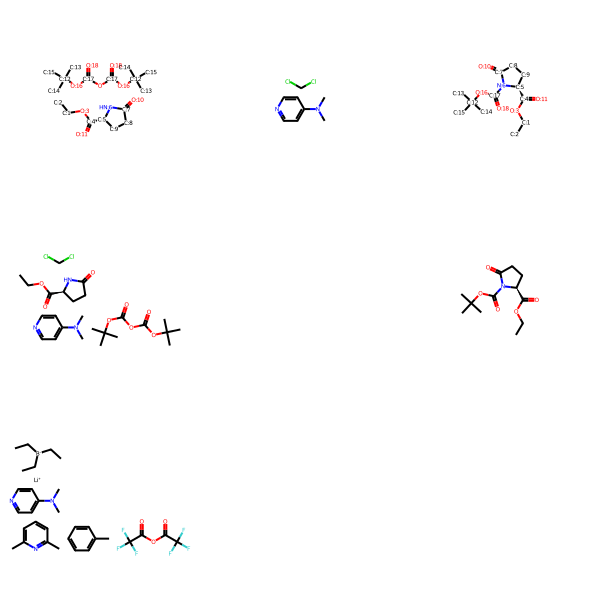

In [21]:
from rdkit import Chem

lowe_smiles = data['smiles']
see_rxns = '>'.join([lowe_smiles] + extracted_rxn_strings)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in see_rxns.split('>')])